<a href="https://colab.research.google.com/github/mariaalabdulrahman/GenAI_Workshop/blob/main/VAE_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example with CIFAR-10 dataset

#### Importing the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#### Dataset Preparation

In [ ]:
# Normalizing the pixel values between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading and preprocessing the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting the dataset into training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


 #### VAE Model Architecture

In [ ]:
latent_dim = 128
# Defining the architecture of the VAE, including the encoder and decoder components
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Implementing the encoder using suitable layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), #in channels=3, out channels=16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mean = nn.Linear(32 * 8 * 8, latent_dim) #32 channels, 8*8, output latent_dim is the desired dimension of latent space
        self.fc_logvar = nn.Linear(32 * 8 * 8, latent_dim)

        # Implementing the decoder with layers that mirror the encoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 8 * 8),
            nn.Unflatten(1, (32, 8, 8)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh() # squashes the input values to the range [-1, 1], good for images
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar): #add random noise
        eps = torch.randn_like(mean)
        return mean + torch.exp(0.5 * logvar) * eps

    def decode(self, z):
        reconstructed = self.decoder(z)
        return reconstructed

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar

#### Loss Function and Training

In [ ]:
# Implementing the objective function for training the VAE
KLD_WEIGHT = 1e-4
def compute_loss(reconstructed, x, mean, logvar):
    # Reconstruction loss
    reconstruction_loss = nn.functional.mse_loss(reconstructed, x)
    # KL Divergence between the approximate posterior q(z|x) and latent prior p(z) assuming them to be normal distributions
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim = 1), dim = 0)
    total_loss = (1-KLD_WEIGHT)*reconstruction_loss + KLD_WEIGHT*kld_loss
    return total_loss

# Initializing the VAE model
vae = VAE(latent_dim)
# Configuring the optimizer and learning rate
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def train_step(model, x, optimizer):
    optimizer.zero_grad()
    reconstructed, mean, logvar = model(x)
    loss = compute_loss(reconstructed, x, mean, logvar)
    loss.backward()
    optimizer.step()
    return loss.item()

def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(train_loader)
        for batch_idx, (data, _) in enumerate(pbar):
            loss = train_step(model, data, optimizer)
            total_loss += loss
            # tqdm decoration
            pbar.set_description(f"Epoch {epoch+1}/{epochs}: ")
            pbar.set_postfix({"loss": loss, "avloss": total_loss/(batch_idx+1)})

# Training the VAE
train(vae, train_loader, optimizer, epochs=20)

Epoch 20/20: : 100%|██████████| 782/782 [00:44<00:00, 17.61it/s, loss=0.0365, avloss=0.0395]


 #### Reconstructing Input Data

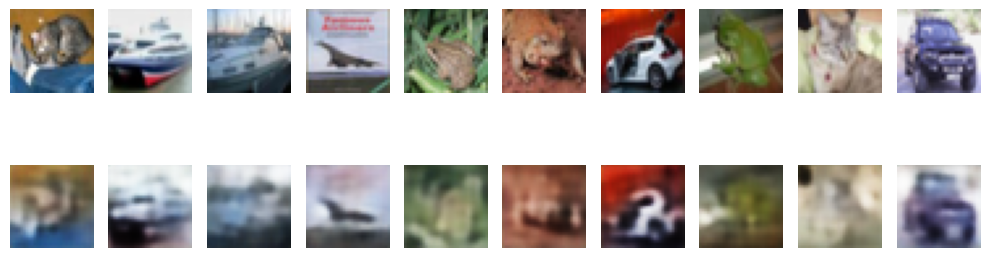

In [ ]:
def reconstruct_input(model, x):
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(x)
    return reconstructed

# Reconstructing input data
sample_input, _ = next(iter(test_loader))
reconstructed_output = reconstruct_input(vae, sample_input)

# Visualizing the original input and its reconstructed counterpart
def denormalize(image):
    image = image / 2 + 0.5 #bring pixel values back to original scale
    return np.transpose(image, (1, 2, 0)) #image is (C, H, W), transposed to (H, W, C) which helps visualize

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
for i in range(10):
    axes[0, i].imshow(denormalize(sample_input[i].numpy()))
    axes[0, i].axis('off')
    axes[1, i].imshow(denormalize(reconstructed_output[i].numpy()))
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()